# Short Term Load Forecasting (Daily)

A range of ML based experiments have been done for daily load forcasting for given parameters (or features).

In [1]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
import time
import gc
from tqdm import tqdm

**Colab Config**

In [2]:
# from google.colab import drive 
# drive.mount ("/content/drive/")

## Architecture of the Work 

$ \fbox{Load Datasets} -->  \fbox{Feature Engineering}  --> \fbox{Data Processing} --> \fbox{Train-Val-Test Split} --> \fbox{Model Training} --> \fbox{Prediction}$ 



## Load Dataset

In this work ISO-NE dataset has been considered. Dataset is taken from this work:
https://github.com/yalickj/load-forecasting-resnet

In [3]:
df_master = pd.read_csv('dataset/selected_data_ISONE.csv') #in laptop
# df_master = pd.read_csv('/content/drive/MyDrive/selected_data_ISONE.csv') #in colab

In [4]:
df_master.head()

,date,year,month,day,weekday,hour,demand,temperature
0,2003/3/1,2003,3,1,7,1,12863.0,23
1,2003/3/1,2003,3,1,7,2,12389.0,22
2,2003/3/1,2003,3,1,7,3,12155.0,21
3,2003/3/1,2003,3,1,7,4,12072.0,21
4,2003/3/1,2003,3,1,7,5,12160.0,22


In [5]:
print("Number of Samples:",df_master.shape[0])
print("Number of Days:" ,len(df_master.date.unique()))

Number of Samples: 103776
Number of Days: 4324


### Data Analysis

<AxesSubplot:>

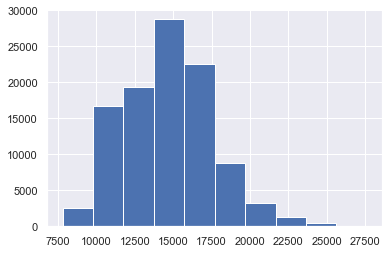

In [6]:
df_master.demand.hist() #histogram of samples

<AxesSubplot:>

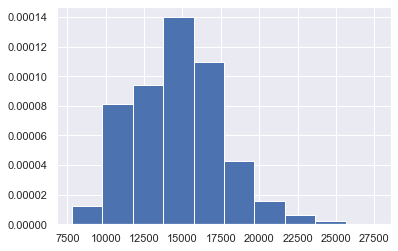

In [7]:
df_master.demand.hist(density=True) #probability density function

## Feature Engineering

The given dataset contains *year, month, day, weekday, hour, demand* and *temperature*. We are going to add *weekday, season* and *festival* into the dataset. We will consider previous 6 hours' load demand as an input.

In [8]:
# add weekday info to the dataset
# the initial value for iter_weekday corresponds to the first day of the dataset
iter_weekday = 6
weekday = np.zeros((24*4324,))
for i in range(4324):
    mod = np.mod(iter_weekday, 7)
    for j in range(24):
        if (mod == 6) or (mod == 0):
            weekday[i*24 + j] = 0
        else:
            weekday[i*24 + j] = 1
    iter_weekday += 1

In [9]:
# add season and festival info to the dataset
import datetime
iter_date = datetime.date(2003, 3, 1)
season = np.zeros((24*4324,))
festival = np.zeros((24*4324,))
for i in range(4324):
    month = iter_date.month
    day = iter_date.day
    for j in range(24):
        if (month==4) | (month==5) | ((month==3) and (day>7)) | ((month==6) and (day<8)):
            season[i*24 + j] = 0 #spring
        elif (month==7) | (month==8) | ((month==6) and (day>7)) | ((month==9) and (day<8)):
            season[i*24 + j] = 1 #summer
        elif (month==10) | (month==11) | ((month==9) and (day>7)) | ((month==12) and (day<8)):
            season[i*24 + j] = 2 #autumn
        elif (month==1) | (month==2) | ((month==12) and (day>7)) | ((month==3) and (day<8)):
            season[i*24 + j] = 3 #winter

        if (month == 7) and (day == 4):
            festival[i*24 + j] = 1
        if (month == 11) and (iter_date.weekday() == 4) and (day + 7 > 30):
            festival[i*24 + j] = 1
        if (month == 12) and (day == 25):
            festival[i*24 + j] = 1
    iter_date = iter_date + datetime.timedelta(1)

In [10]:
df_master['weekday'] = weekday

In [11]:
df_master['season'] = season
df_master['season'] = df_master.apply(lambda x:int(x['season']),axis=1) # to keep it integer
df_master['festival'] = festival

In [12]:
#normalising demand with peak value
MAX_DEMAND = max(df_master.demand)

df_master['demand'] = df_master.demand/MAX_DEMAND

In [13]:
dates = df_master.date.unique()

In [14]:
#taking daywise demands and temparatures
day_demands = []
day_temperatures = []
for date in tqdm(dates):
    temp = df_master[df_master.date==date] #temporary dataset
    demands = temp.demand.tolist()
    temperatures = temp.temperature.tolist()
    day_demands.append(demands)
    day_temperatures.append(temperatures)

del temp
gc.collect()

100%|██████████| 4324/4324 [00:36<00:00, 118.78it/s]


26

In [45]:
df_daily = pd.DataFrame({
    'date':dates,
    'demands':day_demands,
    'temparatures':day_temperatures
})

In [46]:
df_daily = df_daily.merge(df_master[['date','month','weekday','season','festival']].drop_duplicates('date'),on='date',how='left')

In [47]:
df_daily['prev_1day_demands'] = df_daily['demands'].shift(1)
df_daily['prev_2day_demands'] = df_daily['demands'].shift(2)
df_daily['prev_3day_demands'] = df_daily['demands'].shift(3)
df_daily['prev_4day_demands'] = df_daily['demands'].shift(4)
df_daily['prev_5day_demands'] = df_daily['demands'].shift(5)
df_daily['prev_6day_demands'] = df_daily['demands'].shift(6)
df_daily['prev_7day_demands'] = df_daily['demands'].shift(7)

df_daily['prev_month_demands'] = df_daily['demands'].shift(28)

In [48]:
df_daily.head(10)

,date,demands,temparatures,month,weekday,season,festival,prev_1day_demands,prev_2day_demands,prev_3day_demands,prev_4day_demands,prev_5day_demands,prev_6day_demands,prev_7day_demands,prev_month_demands
0,2003/3/1,"[0.4656795308087756, 0.44851929621316344, 0.44...","[23, 22, 21, 21, 22, 21, 22, 22, 24, 27, 30, 3...",3,0.0,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003/3/2,"[0.42940409818260805, 0.4117370212149736, 0.40...","[32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 3...",3,0.0,3,0.0,"[0.4656795308087756, 0.44851929621316344, 0.44...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003/3/3,"[0.4220186807617117, 0.41119397581637823, 0.40...","[35, 34, 31, 28, 23, 18, 14, 10, 8, 7, 8, 9, 1...",3,1.0,3,0.0,"[0.42940409818260805, 0.4117370212149736, 0.40...","[0.4656795308087756, 0.44851929621316344, 0.44...",NaN,NaN,NaN,NaN,NaN,NaN
3,2003/3/4,"[0.5148794439215119, 0.5021359785678082, 0.497...","[6, 5, 4, 4, 4, 4, 4, 6, 8, 12, 16, 20, 24, 27...",3,1.0,3,0.0,"[0.4220186807617117, 0.41119397581637823, 0.40...","[0.42940409818260805, 0.4117370212149736, 0.40...","[0.4656795308087756, 0.44851929621316344, 0.44...",NaN,NaN,NaN,NaN,NaN
4,2003/3/5,"[0.4575338498298458, 0.44109767576569403, 0.43...","[31, 31, 31, 31, 32, 32, 33, 33, 34, 35, 37, 3...",3,1.0,3,0.0,"[0.5148794439215119, 0.5021359785678082, 0.497...","[0.4220186807617117, 0.41119397581637823, 0.40...","[0.42940409818260805, 0.4117370212149736, 0.40...","[0.4656795308087756, 0.44851929621316344, 0.44...",NaN,NaN,NaN,NaN
5,2003/3/6,"[0.43338643110564046, 0.4200637173267685, 0.41...","[37, 36, 35, 33, 31, 30, 29, 28, 28, 27, 27, 2...",3,1.0,3,0.0,"[0.4575338498298458, 0.44109767576569403, 0.43...","[0.5148794439215119, 0.5021359785678082, 0.497...","[0.4220186807617117, 0.41119397581637823, 0.40...","[0.42940409818260805, 0.4117370212149736, 0.40...","[0.4656795308087756, 0.44851929621316344, 0.44...",NaN,NaN,NaN
6,2003/3/7,"[0.48942871624067774, 0.4771920932589965, 0.47...","[12, 10, 9, 6, 6, 5, 3, 5, 9, 13, 17, 20, 22, ...",3,1.0,3,0.0,"[0.43338643110564046, 0.4200637173267685, 0.41...","[0.4575338498298458, 0.44109767576569403, 0.43...","[0.5148794439215119, 0.5021359785678082, 0.497...","[0.4220186807617117, 0.41119397581637823, 0.40...","[0.42940409818260805, 0.4117370212149736, 0.40...","[0.4656795308087756, 0.44851929621316344, 0.44...",NaN,NaN
7,2003/3/8,"[0.462964303815799, 0.4435232785460865, 0.4334...","[25, 26, 27, 27, 27, 26, 26, 24, 28, 31, 35, 3...",3,0.0,0,0.0,"[0.48942871624067774, 0.4771920932589965, 0.47...","[0.43338643110564046, 0.4200637173267685, 0.41...","[0.4575338498298458, 0.44109767576569403, 0.43...","[0.5148794439215119, 0.5021359785678082, 0.497...","[0.4220186807617117, 0.41119397581637823, 0.40...","[0.42940409818260805, 0.4117370212149736, 0.40...","[0.4656795308087756, 0.44851929621316344, 0.44...",NaN
8,2003/3/9,"[0.4234305987980595, 0.4041705886612121, 0.394...","[36, 36, 37, 37, 38, 39, 39, 39, 40, 42, 42, 4...",3,0.0,0,0.0,"[0.462964303815799, 0.4435232785460865, 0.4334...","[0.48942871624067774, 0.4771920932589965, 0.47...","[0.43338643110564046, 0.4200637173267685, 0.41...","[0.4575338498298458, 0.44109767576569403, 0.43...","[0.5148794439215119, 0.5021359785678082, 0.497...","[0.4220186807617117, 0.41119397581637823, 0.40...","[0.42940409818260805, 0.4117370212149736, 0.40...",NaN
9,2003/3/10,"[0.45058286872782566, 0.4417855332705814, 0.43...","[17, 16, 15, 14, 13, 12, 12, 12, 14, 17, 19, 2...",3,1.0,0,0.0,"[0.4234305987980595, 0.4041705886612121, 0.394...","[0.462964303815799, 0.4435232785460865, 0.4334...","[0.48942871624067774, 0.4771920932589965, 0.47...","[0.43338643110564046, 0.4200637173267685, 0.41...","[0.4575338498298458, 0.44109767576569403, 0.43...","[0.5148794439215119, 0.5021359785678082, 0.497...","[0.4220186807617117, 0.41119397581637823, 0.40...",NaN


In [49]:
#filling NaN values
zeros_list = [0]*24

#previous month
for row in df_daily.loc[df_daily.prev_month_demands.isnull(), 'prev_month_demands'].index:
    df_daily.at[row, 'prev_month_demands'] = zeros_list


#previous 7 days
for row in df_daily.loc[df_daily.prev_1day_demands.isnull(), 'prev_1day_demands'].index:
    df_daily.at[row, 'prev_1day_demands'] = zeros_list

for row in df_daily.loc[df_daily.prev_2day_demands.isnull(), 'prev_2day_demands'].index:
    df_daily.at[row, 'prev_2day_demands'] = zeros_list

for row in df_daily.loc[df_daily.prev_3day_demands.isnull(), 'prev_3day_demands'].index:
    df_daily.at[row, 'prev_3day_demands'] = zeros_list

for row in df_daily.loc[df_daily.prev_4day_demands.isnull(), 'prev_4day_demands'].index:
    df_daily.at[row, 'prev_4day_demands'] = zeros_list

for row in df_daily.loc[df_daily.prev_5day_demands.isnull(), 'prev_5day_demands'].index:
    df_daily.at[row, 'prev_5day_demands'] = zeros_list

for row in df_daily.loc[df_daily.prev_6day_demands.isnull(), 'prev_6day_demands'].index:
    df_daily.at[row, 'prev_6day_demands'] = zeros_list

for row in df_daily.loc[df_daily.prev_7day_demands.isnull(), 'prev_7day_demands'].index:
    df_daily.at[row, 'prev_7day_demands'] = zeros_list


## Data Processing
Before fitting data into neural networks model we will do some processing here. In this work demand values are normalized by peak demand value. Season and Month values are one-hot encodded.

List of freatures and their size are shown bellow.
### Features
* dh_x = demand of the $h^{th}$ hour of the day - size 24
* Th_x = temparature of the $h^{th}$ hour of the day - size 24
* prevDn_dh_x = demand of the $h^{th}$ hour of the previous $n^{th}$ day - size 24*7 = 168
* prevM_dh_x = demand of the $h^{th}$ hour of the previous month - size 24

* M - month (one-hot-encoded) - size 12
* W = weekday = 0 or 1 - size 1
* S = Season = 4 (one-hot-encoded) - size 4
* F = festival = 0 or 1 - size 1

Total feature size 258

In [50]:
df_daily = df_daily.assign(**pd.DataFrame(df_daily.demands.values.tolist()).add_prefix('dh_'))
df_daily = df_daily.assign(**pd.DataFrame(df_daily.temparatures.values.tolist()).add_prefix('Th_'))
df_daily = df_daily.assign(**pd.DataFrame(df_daily.prev_1day_demands.values.tolist()).add_prefix('prevD1_dh_'))
df_daily = df_daily.assign(**pd.DataFrame(df_daily.prev_2day_demands.values.tolist()).add_prefix('prevD2_dh_'))
df_daily = df_daily.assign(**pd.DataFrame(df_daily.prev_3day_demands.values.tolist()).add_prefix('prevD3_dh_'))
df_daily = df_daily.assign(**pd.DataFrame(df_daily.prev_4day_demands.values.tolist()).add_prefix('prevD4_dh_'))
df_daily = df_daily.assign(**pd.DataFrame(df_daily.prev_5day_demands.values.tolist()).add_prefix('prevD5_dh_'))
df_daily = df_daily.assign(**pd.DataFrame(df_daily.prev_6day_demands.values.tolist()).add_prefix('prevD6_dh_'))
df_daily = df_daily.assign(**pd.DataFrame(df_daily.prev_7day_demands.values.tolist()).add_prefix('prevD7_dh_'))
df_daily = df_daily.assign(**pd.DataFrame(df_daily.prev_month_demands.values.tolist()).add_prefix('prevM_dh_'))

In [51]:
del df_daily['demands']
del df_daily['temparatures']
del df_daily['prev_1day_demands']
del df_daily['prev_2day_demands']
del df_daily['prev_3day_demands']
del df_daily['prev_4day_demands']
del df_daily['prev_5day_demands']
del df_daily['prev_6day_demands']
del df_daily['prev_7day_demands']
del df_daily['prev_month_demands']


In [52]:
df_onehot = pd.get_dummies(df_daily,columns=["month","season"],prefix=["month","season"])

In [53]:
df_onehot.head(2)

,date,weekday,festival,dh_0,dh_1,dh_2,dh_3,dh_4,dh_5,dh_6,...,month_7,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3
0,2003/3/1,0.0,0.0,0.465680,0.448519,0.440048,0.437043,0.440229,0.455000,0.479183,...,0,0,0,0,0,0,0,0,0,1
1,2003/3/2,0.0,0.0,0.429404,0.411737,0.401311,0.394794,0.395699,0.404279,0.420100,...,0,0,0,0,0,0,0,0,0,1


In [54]:
FECOLS = ['weekday', 'festival', 'dh_0', 'dh_1', 'dh_2', 'dh_3', 'dh_4', 'dh_5', 'dh_6',
          'dh_7', 'dh_8', 'dh_9', 'dh_10', 'dh_11', 'dh_12', 'dh_13', 'dh_14', 'dh_15',
          'dh_16', 'dh_17', 'dh_18', 'dh_19', 'dh_20', 'dh_21', 'dh_22', 'dh_23', 'Th_0',
          'Th_1', 'Th_2', 'Th_3', 'Th_4', 'Th_5', 'Th_6', 'Th_7', 'Th_8', 'Th_9', 'Th_10', 
          'Th_11', 'Th_12', 'Th_13', 'Th_14', 'Th_15', 'Th_16', 'Th_17', 'Th_18', 'Th_19',
          'Th_20', 'Th_21', 'Th_22', 'Th_23', 'prevD1_dh_0', 'prevD1_dh_1', 'prevD1_dh_2',
          'prevD1_dh_3', 'prevD1_dh_4', 'prevD1_dh_5', 'prevD1_dh_6', 'prevD1_dh_7', 'prevD1_dh_8',
          'prevD1_dh_9', 'prevD1_dh_10', 'prevD1_dh_11', 'prevD1_dh_12', 'prevD1_dh_13',
          'prevD1_dh_14', 'prevD1_dh_15', 'prevD1_dh_16', 'prevD1_dh_17', 'prevD1_dh_18',
          'prevD1_dh_19', 'prevD1_dh_20', 'prevD1_dh_21', 'prevD1_dh_22', 'prevD1_dh_23',
          'prevD2_dh_0', 'prevD2_dh_1', 'prevD2_dh_2', 'prevD2_dh_3', 'prevD2_dh_4', 'prevD2_dh_5',
          'prevD2_dh_6', 'prevD2_dh_7', 'prevD2_dh_8', 'prevD2_dh_9', 'prevD2_dh_10', 'prevD2_dh_11',
          'prevD2_dh_12', 'prevD2_dh_13', 'prevD2_dh_14', 'prevD2_dh_15', 'prevD2_dh_16', 'prevD2_dh_17',
          'prevD2_dh_18', 'prevD2_dh_19', 'prevD2_dh_20', 'prevD2_dh_21', 'prevD2_dh_22', 'prevD2_dh_23',
          'prevD3_dh_0', 'prevD3_dh_1', 'prevD3_dh_2', 'prevD3_dh_3', 'prevD3_dh_4', 'prevD3_dh_5',
          'prevD3_dh_6', 'prevD3_dh_7', 'prevD3_dh_8', 'prevD3_dh_9', 'prevD3_dh_10', 'prevD3_dh_11',
          'prevD3_dh_12', 'prevD3_dh_13', 'prevD3_dh_14', 'prevD3_dh_15', 'prevD3_dh_16', 'prevD3_dh_17',
          'prevD3_dh_18', 'prevD3_dh_19', 'prevD3_dh_20', 'prevD3_dh_21', 'prevD3_dh_22', 'prevD3_dh_23',
          'prevD4_dh_0', 'prevD4_dh_1', 'prevD4_dh_2', 'prevD4_dh_3', 'prevD4_dh_4', 'prevD4_dh_5',
          'prevD4_dh_6', 'prevD4_dh_7', 'prevD4_dh_8', 'prevD4_dh_9', 'prevD4_dh_10', 'prevD4_dh_11',
          'prevD4_dh_12', 'prevD4_dh_13', 'prevD4_dh_14', 'prevD4_dh_15', 'prevD4_dh_16', 'prevD4_dh_17',
          'prevD4_dh_18', 'prevD4_dh_19', 'prevD4_dh_20', 'prevD4_dh_21', 'prevD4_dh_22', 'prevD4_dh_23',
          'prevD5_dh_0', 'prevD5_dh_1', 'prevD5_dh_2', 'prevD5_dh_3', 'prevD5_dh_4', 'prevD5_dh_5', 
          'prevD5_dh_6', 'prevD5_dh_7', 'prevD5_dh_8', 'prevD5_dh_9', 'prevD5_dh_10', 'prevD5_dh_11',
          'prevD5_dh_12', 'prevD5_dh_13', 'prevD5_dh_14', 'prevD5_dh_15', 'prevD5_dh_16', 'prevD5_dh_17',
          'prevD5_dh_18', 'prevD5_dh_19', 'prevD5_dh_20', 'prevD5_dh_21', 'prevD5_dh_22', 'prevD5_dh_23',
          'prevD6_dh_0', 'prevD6_dh_1', 'prevD6_dh_2', 'prevD6_dh_3', 'prevD6_dh_4', 'prevD6_dh_5', 
          'prevD6_dh_6', 'prevD6_dh_7', 'prevD6_dh_8', 'prevD6_dh_9', 'prevD6_dh_10', 'prevD6_dh_11', 
          'prevD6_dh_12', 'prevD6_dh_13', 'prevD6_dh_14', 'prevD6_dh_15', 'prevD6_dh_16', 'prevD6_dh_17',
          'prevD6_dh_18', 'prevD6_dh_19', 'prevD6_dh_20', 'prevD6_dh_21', 'prevD6_dh_22', 'prevD6_dh_23',
          'prevD7_dh_0', 'prevD7_dh_1', 'prevD7_dh_2', 'prevD7_dh_3', 'prevD7_dh_4', 'prevD7_dh_5',
          'prevD7_dh_6', 'prevD7_dh_7', 'prevD7_dh_8', 'prevD7_dh_9', 'prevD7_dh_10', 'prevD7_dh_11',
          'prevD7_dh_12', 'prevD7_dh_13', 'prevD7_dh_14', 'prevD7_dh_15', 'prevD7_dh_16', 'prevD7_dh_17',
          'prevD7_dh_18', 'prevD7_dh_19', 'prevD7_dh_20', 'prevD7_dh_21', 'prevD7_dh_22', 'prevD7_dh_23',
          'prevM_dh_0', 'prevM_dh_1', 'prevM_dh_2', 'prevM_dh_3', 'prevM_dh_4', 'prevM_dh_5', 'prevM_dh_6',
          'prevM_dh_7', 'prevM_dh_8', 'prevM_dh_9', 'prevM_dh_10', 'prevM_dh_11', 'prevM_dh_12',
          'prevM_dh_13', 'prevM_dh_14', 'prevM_dh_15', 'prevM_dh_16', 'prevM_dh_17', 'prevM_dh_18',
          'prevM_dh_19', 'prevM_dh_20', 'prevM_dh_21', 'prevM_dh_22', 'prevM_dh_23', 'month_1',
          'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
          'month_10', 'month_11', 'month_12', 'season_0', 'season_1', 'season_2', 'season_3']



TGCOL = ['dh_0', 'dh_1', 'dh_2', 'dh_3',
       'dh_4', 'dh_5', 'dh_6', 'dh_7', 'dh_8', 'dh_9', 'dh_10', 'dh_11',
       'dh_12', 'dh_13', 'dh_14', 'dh_15', 'dh_16', 'dh_17', 'dh_18', 'dh_19',
       'dh_20', 'dh_21', 'dh_22', 'dh_23']

In [55]:
df_onehot.fillna(0,inplace=True)

In [56]:
X_temp = df_onehot[FECOLS].values
Y_temp = df_onehot[TGCOL].values

In [57]:
print(X.shape,y.shape)

(4323, 1, 258) (4324, 24)


In [58]:
X = X_temp[0:X_temp.shape[0]-1]
Y = Y_temp[1:Y_temp.shape[0]]

In [59]:
#reshaping to train on LSTM
X = np.reshape(X,(X.shape[0],1,X.shape[1]))
X.shape

(4323, 1, 258)

## Train-Val-Test Split

In [60]:
from sklearn.model_selection import train_test_split

#dataset splitted into train,val,test as 64%,16%,20%
X_train,X_test,Y_train,Y_test = train_test_split( X,Y,test_size=0.2, random_state=42)
X_train,X_val,Y_train,Y_val = train_test_split( X_train,Y_train,test_size=0.2, random_state=42)

## Model Loading and Analysis

In this section we will analyze the performance of trained neural network models.

In [61]:
from tensorflow.keras.layers import Dense,LSTM,Dropout, Concatenate
from tensorflow.keras import Sequential,Input, optimizers, losses, models, callbacks

In [62]:
from saveweights2 import model_functions as models

### LSTM-DENSE Model

Like ANN this model is also consists of 6 hidden layers. However, first 2 layers are replaced by LSTM layers and subsequent 4 layers are Dense layers. Activation function for dense layers is `selu`. 

In [63]:
model1 = models.get_lstm_model((1,258))
# model1.summary()

In [64]:
model1.load_weights('saveweights2/model_lstm_dense/'+model1.name)

In [66]:
# model1.evaluate(X_test,Y_test)

### LSTM-DENSE Ensemble

4 different LSTM-Dense model is parallaly trained and concatenated to make the prediction. 4 models are internally different.

First model:
* consist of `selu` activation fucntion for dense layers.  kernel_initializer=`glorot_uniform`,

Second model: 
* consist of `elu` activation fucntion for dense layers.  kernel_initializer=`glorot_uniform`,

Third model: 
* consist of `gelu` activation fucntion for dense layers.  kernel_initializer=`random_normal`,

Forth model: 
* consist of `softplus` activation fucntion for dense layers.  kernel_initializer=`random_normal`,

Finally, the last layers of these models are concatenated and pass it to the final layer to make predictions. The main idea is that these 4 models will learn input features differently so that the model as a whole can gain better generalization capability.


In [67]:
model2 = models.get_lstm_model_ensemble((1,258))
# model2.summary()

In [68]:
model2.load_weights('saveweights2/model_lstm_dense_ensemble/'+model2.name)

### Performance Summary 

We have performed a range of experiments for this task with changing layers, activation functions, hyperparameters tuning, etc. The finnal models output are summarized bellow. 


LSTM-DENSE (with dropout) n_h==200

* 1200 Epochs | Best at 1148 loss: 2.9478 - val_loss: 2.9557 | TEST MAPE : 3.0818

LSTM-DENSE-ENSEMBLE

* 1200 Epochs | Best at 1161 loss: 2.7795 - val_loss: 2.8414
 | TEST MAPE : 2.9440



In [69]:
import json

In [70]:
#loading training history of the models 



f = open('saveweights2/model_lstm_dense/history.json')
lstm_dense_history = json.load(f)

f = open('saveweights2/model_lstm_dense_ensemble//history.json')
lstm_dense_ensemble_history = json.load(f)


In [71]:
lstm_loss = lstm_dense_history['loss']
lstm_val_loss = lstm_dense_history['val_loss']

lstm_ensemble_loss=  lstm_dense_ensemble_history['loss']
lstm_ensemble_val_loss=  lstm_dense_ensemble_history['val_loss']

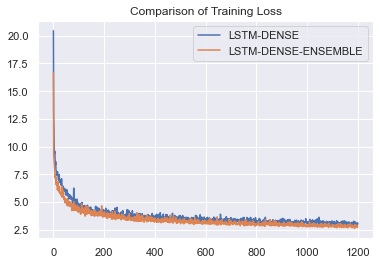

In [72]:
plt.figure()
plt.title('Comparison of Training Loss')
plt.plot(lstm_loss)
plt.plot(lstm_ensemble_loss)
plt.legend(['LSTM-DENSE','LSTM-DENSE-ENSEMBLE'])

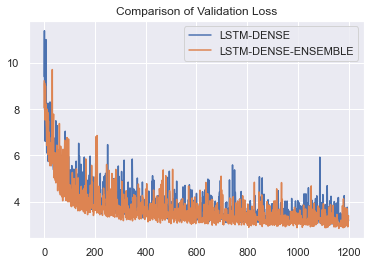

In [73]:
plt.figure()
plt.title('Comparison of Validation Loss')
plt.plot(lstm_val_loss)
plt.plot(lstm_ensemble_val_loss)
plt.legend(['LSTM-DENSE','LSTM-DENSE-ENSEMBLE'])

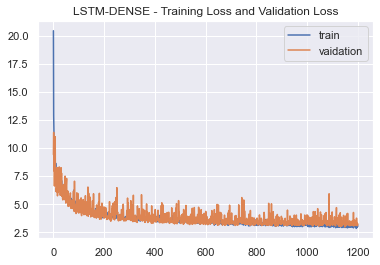

In [74]:
plt.figure()
plt.title('LSTM-DENSE - Training Loss and Validation Loss')
plt.plot(lstm_loss)
plt.plot(lstm_val_loss)
plt.legend(['train','vaidation'])

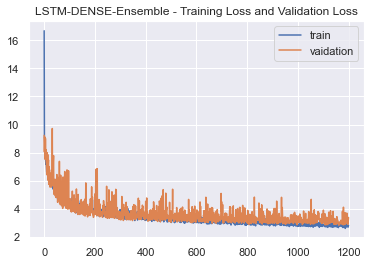

In [75]:
plt.figure()
plt.title('LSTM-DENSE-Ensemble - Training Loss and Validation Loss')
plt.plot(lstm_ensemble_loss)
plt.plot(lstm_ensemble_val_loss)
plt.legend(['train','vaidation'])

## Visualization


In [84]:
def visualize_day(df_onehot,date,nextday,model=None,dense_only=False):
    #extracting data for the given date
    temp = df_onehot[df_onehot.date==date]
    temp_next = df_onehot[df_onehot.date==nextday]
    temp_x = temp[FECOLS].values #input features
    temp_y = temp_next[TGCOL].values * MAX_DEMAND #true demands
    temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))

    #prediction
    preds = model.predict(temp_x)
    if dense_only:
        preds = np.reshape(preds,(24,1))

    y_preds = preds * MAX_DEMAND #predicted demands
    plt.figure()
    plt.plot(temp_y[0])
    plt.plot(y_preds[0])
    plt.legend(["actual","predicted"])
    plt.title(date)

## LSTM-DENSE

In [80]:
import datetime

In [83]:
date=datetime.datetime('2003/7/1')

date += datetime.timedelta(days=1)
date

TypeError: an integer is required (got type str)

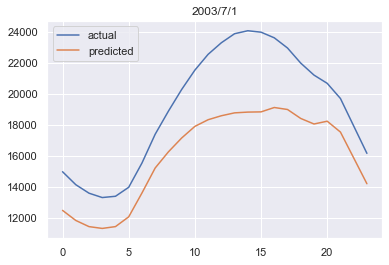

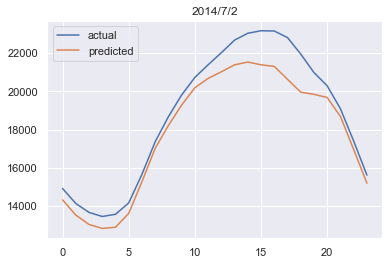

In [85]:
visualize_day(df_onehot,date='2003/7/1',nextday='2014/7/2',model=model1)
visualize_day(df_onehot,date='2014/7/2',nextday='2014/7/3',model=model1)

## LSTM-DENSE Ensemble

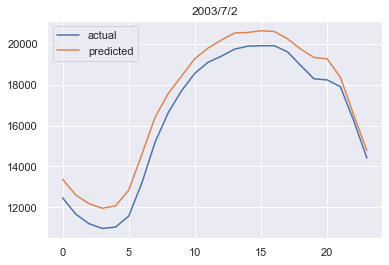

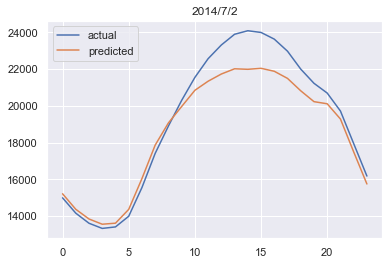

In [84]:
visualize_day(df_onehot,date='2003/7/2',model=model2)
visualize_day(df_onehot,date='2014/7/2',model=model2)

## Visualization for 1 week

In [118]:
df_onehot['date'] = pd.to_datetime(df_onehot['date'])

In [119]:
df_onehot['year'] = df_onehot['date'].dt.year

In [120]:
df_onehot.head(2)

,date,weekday,festival,dh_0,dh_1,dh_2,dh_3,dh_4,dh_5,dh_6,...,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3,year
0,2003-03-01,0.0,0.0,0.465680,0.448519,0.440048,0.437043,0.440229,0.455000,0.479183,...,0,0,0,0,0,0,0,0,1,2003
1,2003-03-02,0.0,0.0,0.429404,0.411737,0.401311,0.394794,0.395699,0.404279,0.420100,...,0,0,0,0,0,0,0,0,1,2003


In [142]:
#extracting 1 week data for the given year and month
temp = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]


temp_x = temp[FECOLS].values #input features
temp_y = temp[TGCOL].values
temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))


<ipython-input-142-1e080a87f79c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]


## LSTM-DENSE

In [148]:
#prediction
preds = model1.predict(temp_x)

In [149]:
y_truth = temp_y[0:7] * MAX_DEMAND
y_preds = abs(preds[0:7]) * MAX_DEMAND

In [150]:
y_preds = np.reshape(y_preds,(24*7))
y_truth = np.reshape(y_truth,(24*7))

Text(0.5, 1.0, '2014 January')

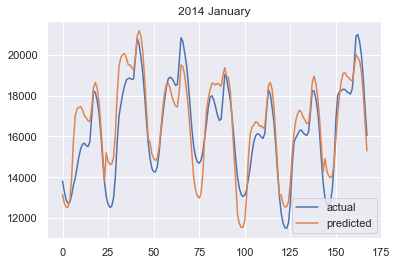

In [152]:
plt.figure()
plt.plot(y_truth)
plt.plot(y_preds)
plt.legend(["actual","predicted"])
plt.title('2014 January')

## LSTM-DENSE Ensemble

In [174]:
#prediction
preds = model2.predict(temp_x)

In [175]:
y_preds = abs(preds[0:7]) * MAX_DEMAND
y_preds = np.reshape(y_preds,(24*7))

Text(0.5, 1.0, '2014 January')

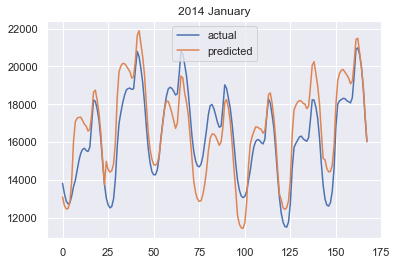

In [176]:
plt.figure()
plt.plot(y_truth)
plt.plot(y_preds)
plt.legend(["actual","predicted"])
plt.title('2014 January')

## Performance Analysis

Here we will visualise 95$\%$ confidence interval for 2 models. 

In [197]:
temp_2014_january = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]

<ipython-input-197-469edaa302a0>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_2014_january = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]


In [198]:
temp_x = temp_2014_january[FECOLS].values #input features
temp_y = temp_2014_january[TGCOL].values #true demands
temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))

## LSTM-DENSE

In [199]:
preds = model1.predict(temp_x)

In [204]:
preds = np.reshape(preds,(31*24))

In [227]:
hours = [i for i in range(1,32) for i in range(0,24)]

In [230]:
temp_df = pd.DataFrame({
    'hour':hours,
    'predicted':preds
})

Text(0.5, 1.0, 'Actual load and 95% prediction intervals for January 2014')

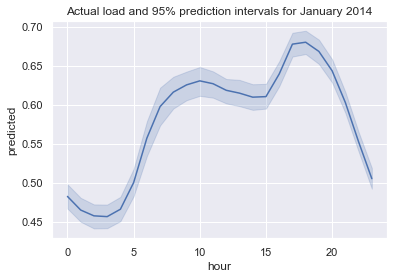

In [231]:
sns.lineplot(x='hour',y='predicted',data=temp_df,ci=95)
plt.title('Actual load and 95% prediction intervals for January 2014')

## LSTM-DENSE-ENSEMBLE

In [235]:
preds = model2.predict(temp_x)
preds = np.reshape(preds,(31*24))

In [236]:
temp_df = pd.DataFrame({
    'hour':hours,
    'predicted':preds
})

Text(0.5, 1.0, 'Actual load and 95% prediction intervals for January 2014')

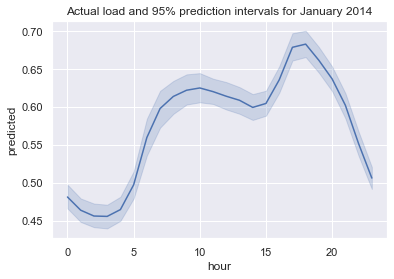

In [237]:
sns.lineplot(x='hour',y='predicted',data=temp_df,ci=95)
plt.title('Actual load and 95% prediction intervals for January 2014')

## Extrapolate for Different Duration 

#### Extrapolation Analysis for 2014

In [188]:
# temp = df_onehot[df_onehot.year==2014]
# temp.reset_index(drop=True,inplace=True)
# temp[['hour','prev_hour_1', 'prev_hour_2',
#           'prev_hour_3', 'prev_hour_4','prev_hour_5', 'prev_hour_6']].head()

In [189]:
# temp_x = temp[FECOLS].values
# temp_y = temp[TGCOL].values

In [190]:
# temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))

In [191]:
# df_extrapolate = temp.copy()
# start_prev_1 = df_extrapolate.iloc[0].prev_hour_1
# start_prev_2 = df_extrapolate.iloc[0].prev_hour_2
# start_prev_3 = df_extrapolate.iloc[0].prev_hour_3
# start_prev_4 = df_extrapolate.iloc[0].prev_hour_4
# start_prev_5 = df_extrapolate.iloc[0].prev_hour_5
# start_prev_6 = df_extrapolate.iloc[0].prev_hour_6

In [192]:
# df_extrapolate['prev_hour_1'] = 0
# df_extrapolate['prev_hour_2'] = 0
# df_extrapolate['prev_hour_3'] = 0
# df_extrapolate['prev_hour_4'] = 0
# df_extrapolate['prev_hour_5'] = 0
# df_extrapolate['prev_hour_6'] = 0
# df_extrapolate['predicted'] = 0

# df_extrapolate.loc[0,'prev_hour_1'] = start_prev_1
# df_extrapolate.loc[0,'prev_hour_2'] = start_prev_2
# df_extrapolate.loc[0,'prev_hour_3'] = start_prev_3
# df_extrapolate.loc[0,'prev_hour_4'] = start_prev_4
# df_extrapolate.loc[0,'prev_hour_5'] = start_prev_5
# df_extrapolate.loc[0,'prev_hour_6'] = start_prev_6

# df_master['prev_hour_1'] = df_master['demand'].shift(1)
# df_master['prev_hour_2'] = df_master['demand'].shift(2)
# df_master['prev_hour_3'] = df_master['demand'].shift(3)
# df_master['prev_hour_4'] = df_master['demand'].shift(4)
# df_master['prev_hour_5'] = df_master['demand'].shift(5)
# df_master['prev_hour_6'] = df_master['demand'].shift(6)

In [186]:
# df_extrapolate.head()

In [187]:
# from tqdm import tqdm

In [184]:
# for index in tqdm(range(df_extrapolate.shape[0])):
#     sample = df_extrapolate[index:index+1]
#     X = sample[FECOLS].values
#     X = np.reshape(X,(X.shape[0],1,X.shape[1]))
    
#     pred = model2.predict(X)
    
#     #storing values in dataframe
#     df_extrapolate.loc[index,'predicted'] = pred.tolist()[0][0]
#     df_extrapolate.loc[index+1,'prev_hour_1'] = pred.tolist()[0][0]
#     df_extrapolate.loc[index+1,'prev_hour_2'] = df_extrapolate.loc[index,'prev_hour_1']
#     df_extrapolate.loc[index+1,'prev_hour_3'] = df_extrapolate.loc[index,'prev_hour_2']
#     df_extrapolate.loc[index+1,'prev_hour_4'] = df_extrapolate.loc[index,'prev_hour_3']
#     df_extrapolate.loc[index+1,'prev_hour_5'] = df_extrapolate.loc[index,'prev_hour_4']
#     df_extrapolate.loc[index+1,'prev_hour_6'] = df_extrapolate.loc[index,'prev_hour_5']
    

In [148]:
# df_extrapolate[['hour','prev_hour_1', 'prev_hour_2',
#           'prev_hour_3', 'prev_hour_4','prev_hour_5', 'prev_hour_6']].head()

,hour,prev_hour_1,prev_hour_2,prev_hour_3,prev_hour_4,prev_hour_5,prev_hour_6
0,1.0,0.528745,0.555897,0.585475,0.613207,0.641192,0.671132
1,2.0,0.499941,0.528745,0.555897,0.585475,0.613207,0.641192
2,3.0,0.486926,0.499941,0.528745,0.555897,0.585475,0.613207
3,4.0,0.480748,0.486926,0.499941,0.528745,0.555897,0.585475
4,5.0,0.481034,0.480748,0.486926,0.499941,0.528745,0.555897


In [149]:
# gc.collect()

182593

In [150]:
# from tensorflow.keras.losses import MeanAbsolutePercentageError as mape

In [151]:
# loss_object = mape()

### A Day Ahead

In [171]:
# day = df_extrapolate[0:24]

# y_true = day['demand'].dropna()
# y_pred = day['predicted'].dropna()

In [172]:
# loss = loss_object(y_true,y_pred)
# loss.numpy()

10.87806224822998

### A Week Ahead

In [152]:
# week = df_extrapolate[0:7*24]

In [153]:
# y_true = week['demand'].dropna()
# y_pred = week['predicted'].dropna()

In [154]:
# loss = loss_object(y_true,y_pred)
# loss.numpy()

4.041378974914551

### A Month Ahead

In [155]:
# month = df_extrapolate[0:30*24]

In [156]:
# y_true = month['demand'].dropna()
# y_pred = month['predicted'].dropna()

In [157]:
# loss = loss_object(y_true,y_pred)
# loss.numpy()

2.387392044067383

### A Year Ahead

In [158]:
# y_true = df_extrapolate['demand'].dropna()
# y_pred = df_extrapolate['predicted'].dropna()

In [159]:
# loss = loss_object(y_true,y_pred)
# loss.numpy()

4.248743057250977

In [181]:
# plt.figure(figsize=(16,8))
# plt.plot(y_true[0:504])
# plt.plot(y_pred[0:504])
# plt.legend(['Actual','Predicted'])

In [182]:
# losses = []
# for i in range(1,13):
#     m_str = "month_"+str(i)
#     y_true = df_extrapolate[df_extrapolate[m_str]==1]['demand'].dropna()
#     y_pred = df_extrapolate[df_extrapolate[m_str]==1]['predicted'].dropna()
#     loss = loss_object(y_true,y_pred)
#     losses.append(loss.numpy())

In [183]:
# best = 100
# for i,loss in enumerate(lstm_loss,1):
#     if best>lstm_val_loss[i]:
#         best =lstm_val_loss[i]
#         best_at = i
#     print('Epoch:',i)
#     print(f'Best at {best_at} loss: {lstm_loss[i]} - val_loss: {lstm_val_loss[i]}\n',)
    